In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np
print("Current working directory:", os.getcwd())

Current working directory: /Users/matiaslein/Desktop/Proyecto-final-ML/entrenamientos_df_intermedio


In [3]:
# Cargar dataset
dataset1 = pd.read_csv('../dataset_basico.csv')
dataset2 = pd.read_csv('../datasetintermedio.csv')

X1, y1 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']
X2, y2 = dataset2.drop(columns='Precio_usd'), dataset2['Precio_usd']


x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [4]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint, uniform
import numpy as np

# RMSE negativo para GridSearch
neg_rmse = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=True
)

# Hiperparámetros a buscar
param_dist = {
    "n_estimators":      randint(200, 1200),
    "max_depth":         randint(4, 40),
    "max_features":      uniform(0.3, 0.7),
    "min_samples_split": randint(2, 15),
    "min_samples_leaf":  randint(1, 10)
}


In [5]:
search1 = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring=neg_rmse,
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

search1.fit(x1_train, y1_train)
print("✅ Dataset 1 - Mejor RMSE CV:", -search1.best_score_)
print("Hiperparámetros óptimos modelo 1:", search1.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Dataset 1 - Mejor RMSE CV: 4727.967403564963
Hiperparámetros óptimos modelo 1: {'max_depth': 24, 'max_features': np.float64(0.5720741027826374), 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 991}


In [9]:
search2 = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring=neg_rmse,
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

search2.fit(x2_train, y2_train)
print("✅ Dataset 2 - Mejor RMSE CV:", -search2.best_score_)
print("Hiperparámetros óptimos modelo 2:", search2.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Dataset 2 - Mejor RMSE CV: 7577.99729363452
Hiperparámetros óptimos modelo 2: {'max_depth': 24, 'max_features': np.float64(0.5720741027826374), 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 991}


In [10]:
# Modelo 1
model_1 = search1.best_estimator_
model_1.fit(x1_train, y1_train)
y1_pred = model_1.predict(x1_test)
rmse_1 = np.sqrt(mean_squared_error(y1_test, y1_pred))

# Modelo 2
model_2 = search2.best_estimator_
model_2.fit(x2_train, y2_train)
y2_pred = model_2.predict(x2_test)
rmse_2 = np.sqrt(mean_squared_error(y2_test, y2_pred))


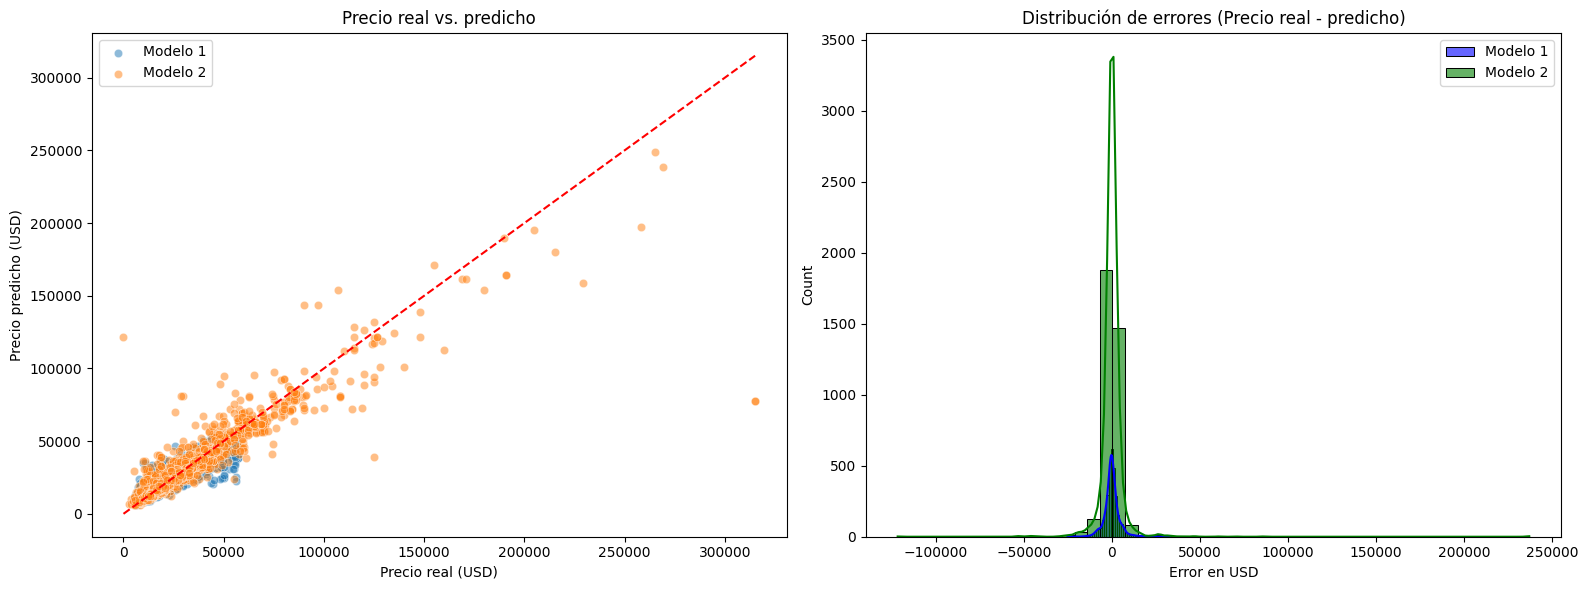

In [11]:
# Errores
errores_1 = y1_test - y1_pred
errores_2 = y2_test - y2_pred

# Métricas
from sklearn.metrics import mean_absolute_error, r2_score

mae1 = mean_absolute_error(y1_test, y1_pred)
r21 = r2_score(y1_test, y1_pred)

mae2 = mean_absolute_error(y2_test, y2_pred)
r22 = r2_score(y2_test, y2_pred)

import matplotlib.pyplot as plt
import seaborn as sns

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ------------------------
# Gráfico 1: Real vs. Predicho
# ------------------------
sns.scatterplot(ax=axes[0], x=y1_test, y=y1_pred, label='Modelo 1', alpha=0.5)
sns.scatterplot(ax=axes[0], x=y2_test, y=y2_pred, label='Modelo 2', alpha=0.5)

# Línea ideal (predicción perfecta)
min_val = min(y1_test.min(), y2_test.min())
max_val = max(y1_test.max(), y2_test.max())
axes[0].plot([min_val, max_val], [min_val, max_val], '--', color='red')

axes[0].set_title("Precio real vs. predicho")
axes[0].set_xlabel("Precio real (USD)")
axes[0].set_ylabel("Precio predicho (USD)")
axes[0].legend()

# ------------------------
# Gráfico 2: Histograma de errores
# ------------------------
sns.histplot(errores_1, bins=50, kde=True, label='Modelo 1', ax=axes[1], color='blue', alpha=0.6)
sns.histplot(errores_2, bins=50, kde=True, label='Modelo 2', ax=axes[1], color='green', alpha=0.6)

axes[1].set_title("Distribución de errores (Precio real - predicho)")
axes[1].set_xlabel("Error en USD")
axes[1].legend()

# ------------------------
plt.tight_layout()
plt.show()



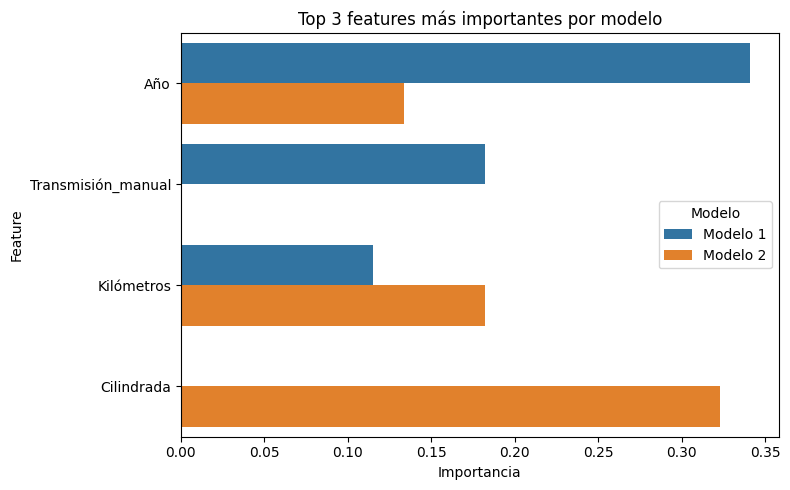

In [19]:

# Obtener top 3 de cada modelo
top1 = pd.DataFrame({
    'Feature': X1.columns,
    'Importancia': model_1.feature_importances_
}).sort_values(by='Importancia', ascending=False).head(3)
top1['Modelo'] = 'Modelo 1'

top2 = pd.DataFrame({
    'Feature': X2.columns,
    'Importancia': model_2.feature_importances_
}).sort_values(by='Importancia', ascending=False).head(3)
top2['Modelo'] = 'Modelo 2'

# Unir en un solo DataFrame
top_combined = pd.concat([top1, top2], axis=0)
# Unificar nombres para graficar
top_combined['Feature'] = top_combined['Feature'].replace({
    'Kilómetros': 'Kilómetros',
    'Kilómetros_num': 'Kilómetros'
})
# Gráfico combinado
plt.figure(figsize=(8, 5))
sns.barplot(data=top_combined, x='Importancia', y='Feature', hue='Modelo')
plt.title("Top 3 features más importantes por modelo")
plt.tight_layout()
plt.show()

/var/folders/h8/075vvj7s65sgq5xnd_m0zfkc0000gn/T/ipykernel_63788/2119603922.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y2_test, label="Real", shade=True)
/var/folders/h8/075vvj7s65sgq5xnd_m0zfkc0000gn/T/ipykernel_63788/2119603922.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y2_pred, label="Predicho", shade=True)


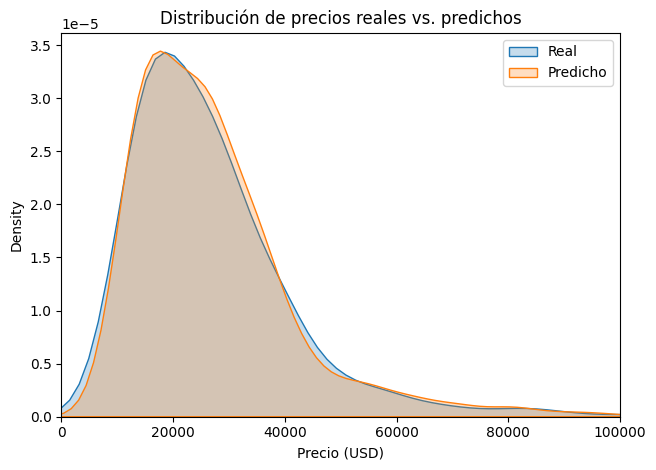

Rango de precio (USD)           MAE (USD)
------------------------------------------
102 – 16,738                        $1881
16,738 – 23,900                     $1977
23,900 – 32,759                     $2422
32,759 – 315,000                    $5877


/var/folders/h8/075vvj7s65sgq5xnd_m0zfkc0000gn/T/ipykernel_63788/2119603922.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  errores_por_cuartil = df_resultado.groupby('precio_q')['error_abs'].mean().reset_index()


In [27]:
sns.kdeplot(y2_test, label="Real", shade=True)
sns.kdeplot(y2_pred, label="Predicho", shade=True)
plt.title("Distribución de precios reales vs. predichos")
plt.xlabel("Precio (USD)")
plt.legend()
plt.tight_layout()
plt.xlim(0, 100000)
plt.show()


# Calcular error por cuartil de precio
df_resultado = pd.DataFrame({'real': y2_test, 'pred': y2_pred})
df_resultado['error_abs'] = np.abs(df_resultado['real'] - df_resultado['pred'])
df_resultado['precio_q'] = pd.qcut(df_resultado['real'], q=4)

# Agrupar y mostrar tabla
errores_por_cuartil = df_resultado.groupby('precio_q')['error_abs'].mean().reset_index()

# Imprimir en formato tabla
print(f"{'Rango de precio (USD)':<30} {'MAE (USD)':>10}")
print("-" * 42)
for idx, row in errores_por_cuartil.iterrows():
    rango = f"{int(row['precio_q'].left):,} – {int(row['precio_q'].right):,}"
    mae = f"${row['error_abs']:.0f}"
    print(f"{rango:<30} {mae:>10}")